Copyright 2020 Google LLC.

Licensed under the Apache License, Version 2.0 (the \"License\")

In [2]:
#@title License
# Licensed under the Apache License, Version 2.0 (the \"License\");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an \"AS IS\" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Single image to MPI example Colab

This Colab is part of code for the paper ___Single-view view synthesis with multiplane images___, and may be found at <br>https://github.com/google-research/google-research/tree/master/single_view_mpi.

The project site is at https://single-view-mpi.github.io/.

Choose __Run all__ from the Runtime menu to:
* set up the network and load our trained model,
* apply it to an RGB input to generate a 32-layer MPI,
* show individual MPI layers and synthesized disparity,
* render novel views from different camera positions,
* visualize the resulting MPI in an HTML-based viewer.


## Download library code, model weights, and example image.

In [3]:
!echo Fetching code from github...
!apt install subversion
!svn export --force https://github.com/google-research/google-research/trunk/single_view_mpi

!echo
!echo Fetching trained model weights...
!rm single_view_mpi_full_keras.tar.gz
!rm -rf single_view_mpi_full
!wget https://storage.googleapis.com/stereo-magnification-public-files/models/single_view_mpi_full_keras.tar.gz
!tar -xzvf single_view_mpi_full_keras.tar.gz

!echo
!echo Fetching example image...
!rm -f input.png
!wget https://single-view-mpi.github.io/mpi/7/input.png


Fetching code from github...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 subversion
0 upgraded, 5 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,237 kB of archives.
After this operation, 9,910 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libapr1 amd64 1.6.3-2 [90.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaprutil1 amd64 1.6.1-2 [84.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libserf-1-1 amd64 1.3.9-6 [44.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libsvn1 amd64 1.9.7-4ubuntu1 [1,183 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/universe amd64 sub

## Set up the model


In [4]:
pip install -r single_view_mpi/requirements.txt

     |████████████████████████████████| 516.2 MB 4.4 kB/s 
     |████████████████████████████████| 1.0 MB 57.4 MB/s 
     |████████████████████████████████| 2.9 MB 43.5 MB/s 
     |████████████████████████████████| 454 kB 64.9 MB/s 
     |████████████████████████████████| 3.0 MB 58.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Fo

In [5]:
import tensorflow as tf

from single_view_mpi.libs import mpi
from single_view_mpi.libs import nets

input = tf.keras.Input(shape=(None, None, 3))
output = nets.mpi_from_image(input)

model = tf.keras.Model(inputs=input, outputs=output)
print('Model created.')
# Our full model, trained on RealEstate10K.
model.load_weights('single_view_mpi_full_keras/single_view_mpi_keras_weights')
print('Weights loaded.')


Model created.
Weights loaded.


## Generate an MPI from an input image, show layers and disparity

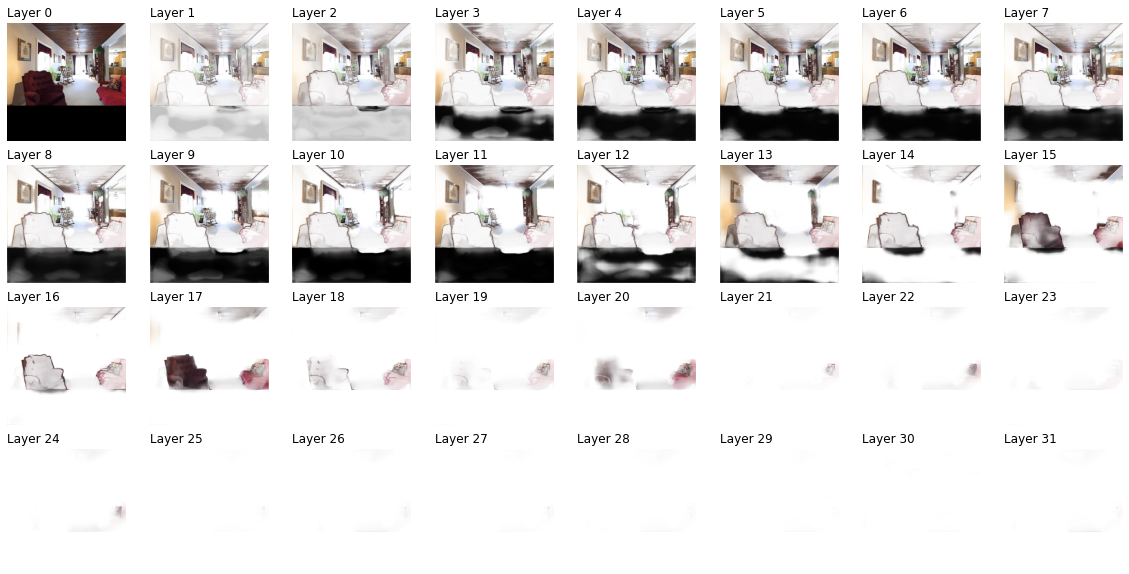

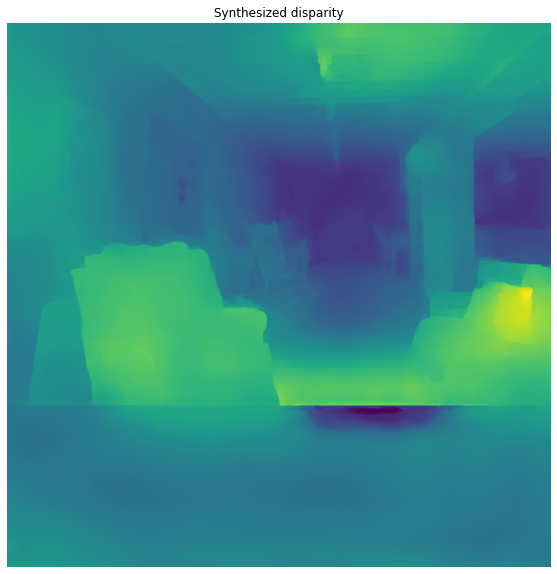

In [6]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (20, 10)

# Input image
inputfile = '55922000.jpg'

input_rgb = tf.image.decode_image(tf.io.read_file(inputfile), dtype=tf.float32)
# Generate MPI
# print(input_rgb.shape)
N, H, W, C = input_rgb[tf.newaxis].shape
# enforce square representation for 1024 x 1024 images
arr = np.zeros((1, 1024 - H, W, C))
representation = np.append(input_rgb[tf.newaxis], arr, axis=1)
representation = representation[0:1, 0:1024, 0: 1024, 0:3]
layers = model(representation)[0]

depths = mpi.make_depths(1.0, 100.0, 32).numpy()

# Layers is now a tensor of shape [L, H, W, 4].
# This represents an MPI with L layers, each of height H and width W, and
# each with an RGB+Alpha 4-channel image.

# Depths is a tensor of shape [L] which gives the depths of the L layers.

# Display layer images
for i in range(32):
  plt.subplot(4, 8, i+1)
  plt.imshow(layers[i])
  plt.axis('off')
  plt.title('Layer %d' % i, loc='left')
plt.show()

# Display computed disparity
disparity = mpi.disparity_from_layers(layers, depths)
plt.imshow(disparity[..., 0])
plt.axis('off')
plt.title('Synthesized disparity')
plt.show()

## Generate new views from nearby camera positions

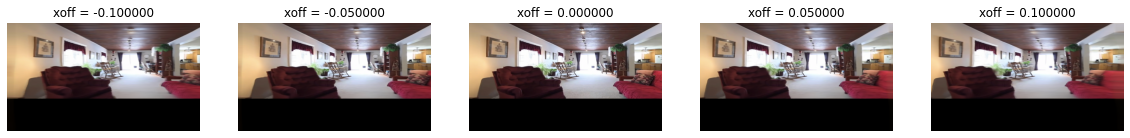

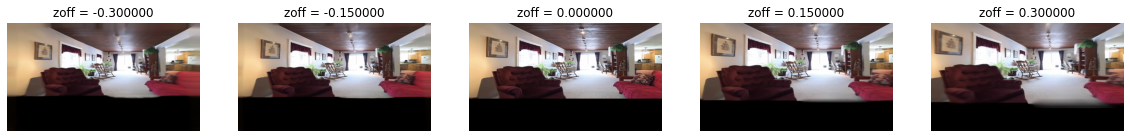

In [7]:
# The reference camera position can just be the identity
reference_pose = tf.constant(
    [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0]])

# Accurate intrinsics are only important if we are trying to match a ground
# truth output. Here we just give intrinsics for a 16:9 image with the
# principal point in the center.
intrinsics = tf.constant([1.0, 1.0 * 16/9, 0.5, 0.5])

def render(xoffset, yoffset, zoffset):
  # The translation is the final column of the pose matrix
  target_pose = tf.constant(
    [[1.0, 0.0, 0.0, -xoffset],
     [0.0, 1.0, 0.0, -yoffset],
     [0.0, 0.0, 1.0, -zoffset]])
  image = mpi.render(layers, depths,
                     reference_pose, intrinsics,  # Reference view
                     target_pose, intrinsics,  # Target view
                     height=512, width=910)
  return image

# First move the camera along the X axis (left to right):
for i in range(5):
  xoffset = (i - 2) * 0.05
  plt.subplot(1, 5, i + 1)
  plt.imshow(render(xoffset, 0.0, 0.0))
  plt.title('xoff = %f' % xoffset)
  plt.axis('off')
plt.show()

# And next along the Z-axis (moving forwards):
for i in range(5):
  zoffset = (i - 2) * 0.15
  plt.subplot(1, 5, i + 1)
  plt.imshow(render(0.0, 0.0, zoffset))
  plt.title('zoff = %f' % zoffset)
  plt.axis('off')
plt.show()


## A simple MPI-viewer using HTML + CSS transforms

In [8]:
import base64

def imgurl(image):
  # We resize layers to 512x288 so the whole stack can be serialized in a
  # Colab for the HTML viewer without hitting the memory restriction. Outside
  # Colab there is no such restriction and 512x512 layers could be used.
  image = tf.image.resize(image, [288, 512], method='area')
  data = tf.image.encode_png(
      tf.image.convert_image_dtype(image, tf.uint8)).numpy()
  dataurl = 'data:image/png;base64,{}'.format(base64.b64encode(data).decode())
  return dataurl

def html_viewer(layers, depths):
  html = []

  html.append('''
  <style>
  #view {
    position: relative;
    overflow: hidden;
    border: 20px solid black;
    width: 512px;
    height: 288px;
    perspective: 500px;
    background: #888;
  }
  #mpi {
    transform-style: preserve-3d; -webkit-transform-style: preserve-3d;
    height: 100%;
    width: 100%;
    pointer-events: none;
  }
  .layer {
    position: absolute;
    background-size: 100% 100%;
    background-repeat: no-repeat;
    background-position: center;
    width: 100%;
    height: 100%;
  }
  </style>''')
  html.append('<h1>MPI Viewer</h1>Hover over the image to control the view.')
  html.append('<div id=view><div id=mpi>')
  for i in range(len(depths)):
    depth = depths[i]
    url = imgurl(layers[i])
    html.append('''
        <div class=layer
             style="transform: scale(%.3f) translateZ(-%.3fpx);
             background-image: url(%s)"></div>''' % (depth, depth, url))

  html.append('</div></div>')
  html.append('''
  <script>
  function setView(mpi, x, y) {
    x = 2*x - 1;
    y = 2*y - 1;
    rx = (-1.5 * y).toFixed(2);
    ry = (2.0 * x).toFixed(2);
    // Put whatever CSS transform you want in here.
    mpi.style.transform =
        `rotateX(${rx}deg) rotateY(${ry}deg) translateZ(500px) scaleZ(500)`;
  }

  view = document.querySelector('#view');
  mpi = document.querySelector('#mpi');
  setView(mpi, 0.5, 0.5);

  // View animates by itself, or you can hover over the image to control it.
  let t = 0;
  let animate = true;
  function tick() {
    if (!animate) {
      return;
    }
    t = (t + 1) % 300;
    r = Math.PI * 2 * t / 300;
    setView(mpi, 0.5 + 0.3 * Math.cos(r), 0.5 + 0.3 * Math.sin(r));
    requestAnimationFrame(tick);
  }
  tick();

  view.addEventListener('mousemove',
    (e) => {animate=false; setView(mpi, e.offsetX/view.offsetWidth, e.offsetY/view.offsetHeight);});
  view.addEventListener('mouseleave',
    (e) => {animate=true; tick();});
  </script>
  ''')
  return ''.join(html)



## View the MPI in a live 3D web viewer


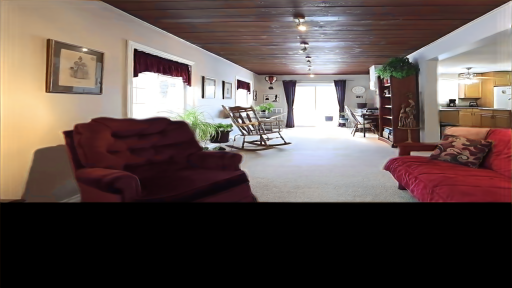
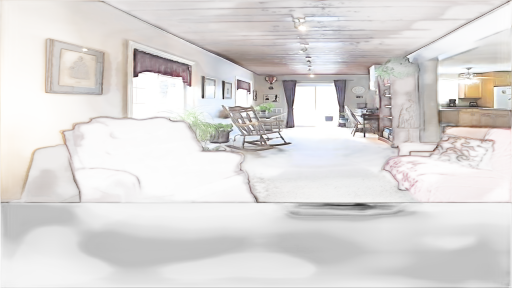
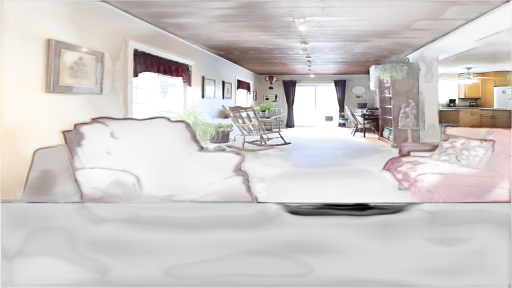
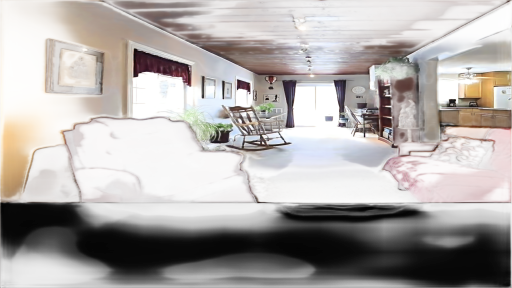
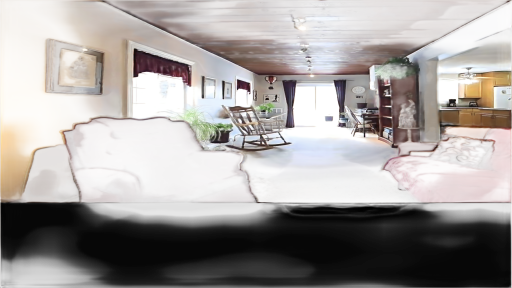
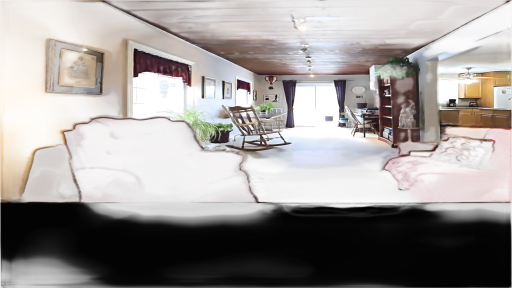
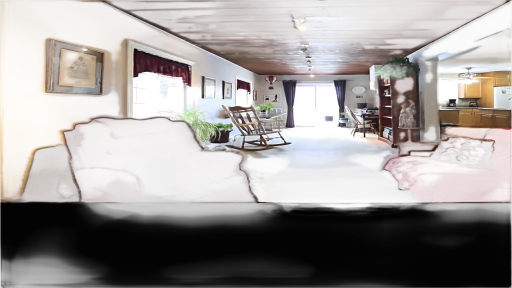
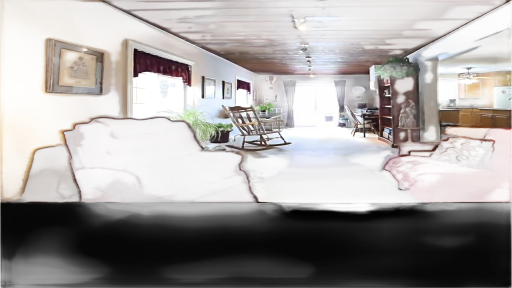
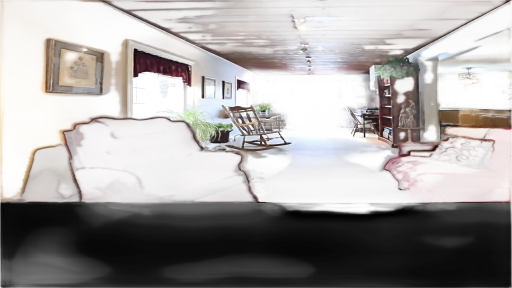
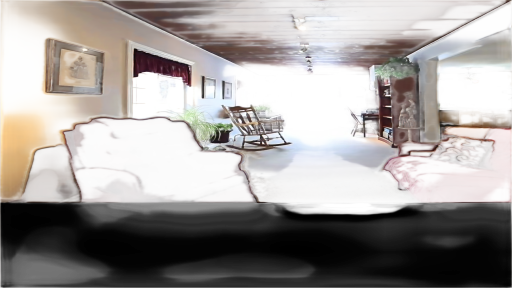
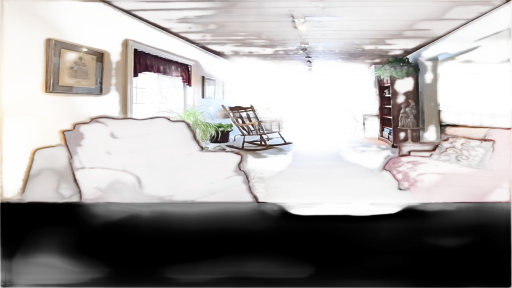
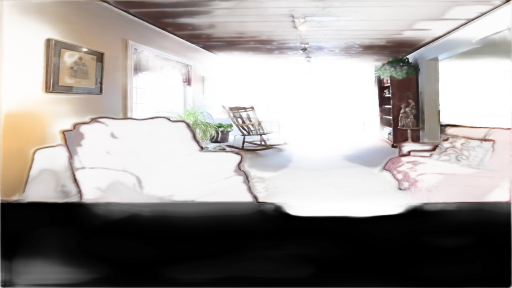
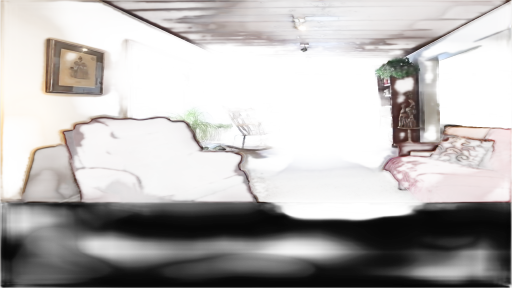
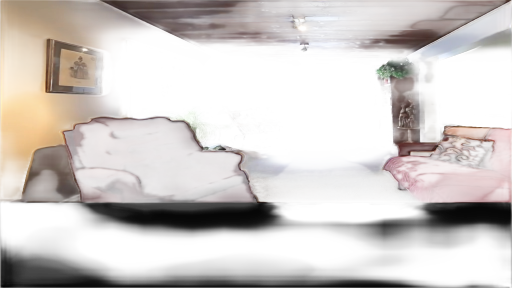
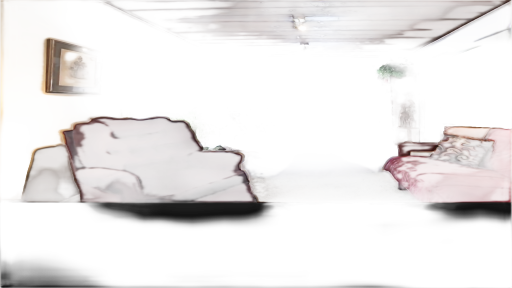
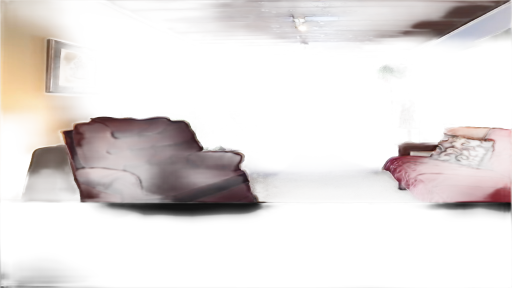
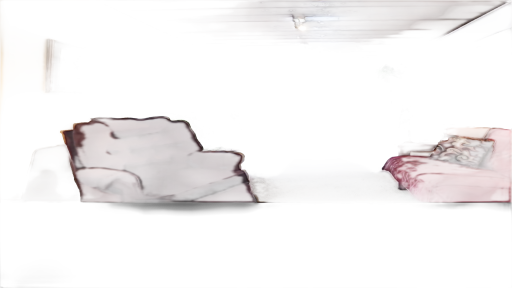
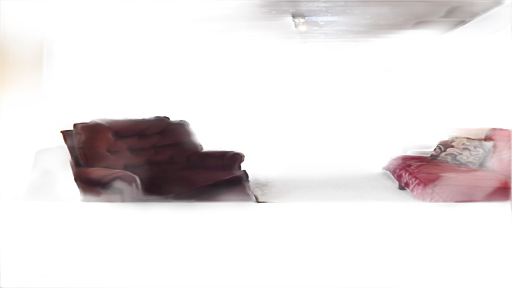
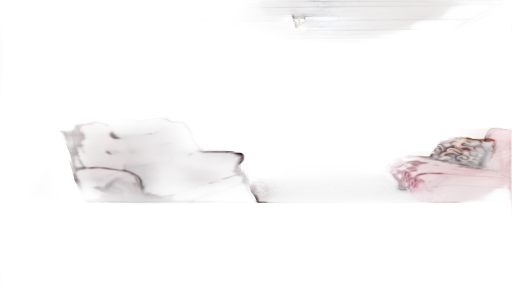
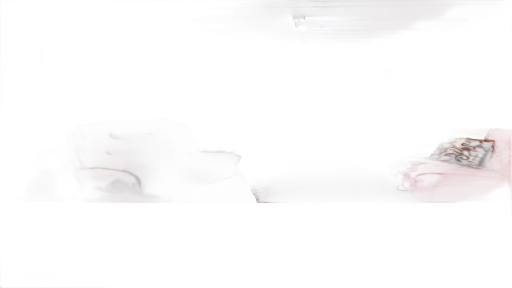
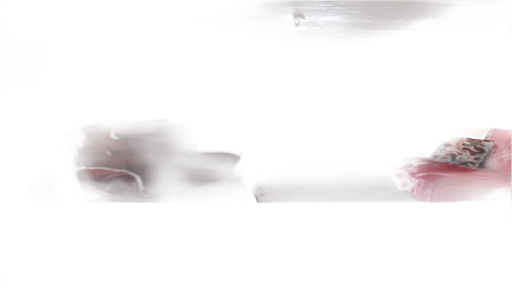
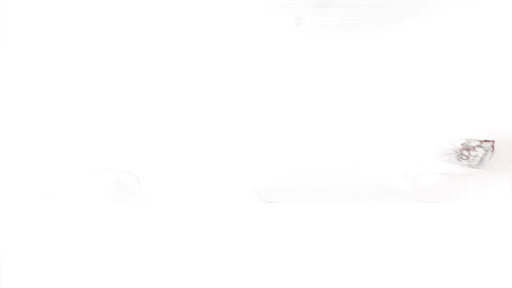
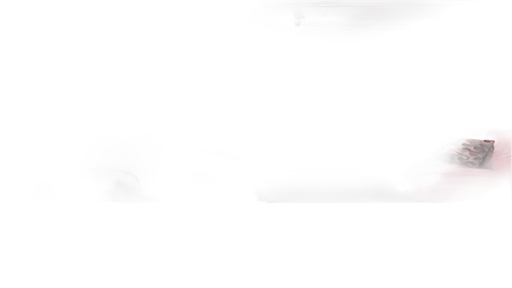
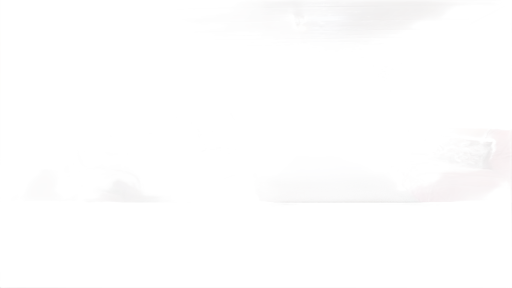
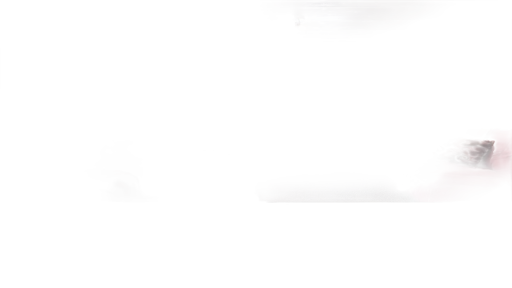
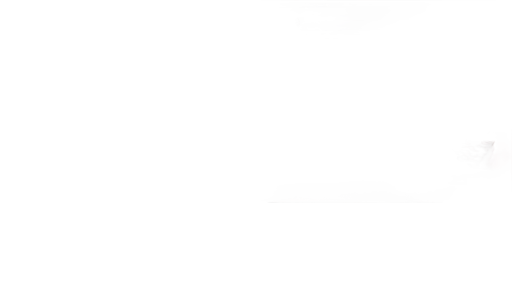
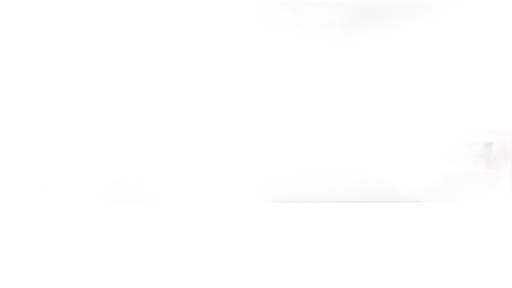
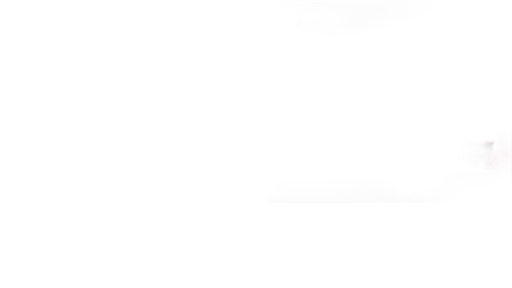
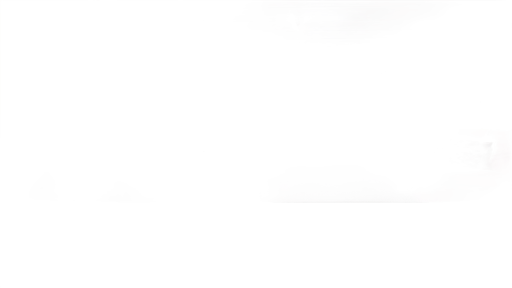
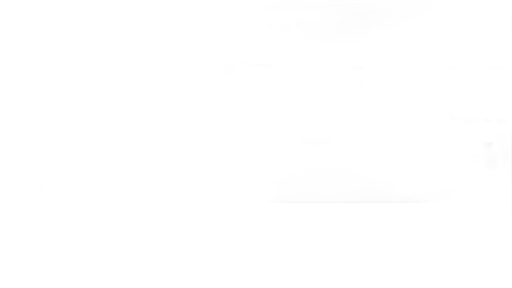
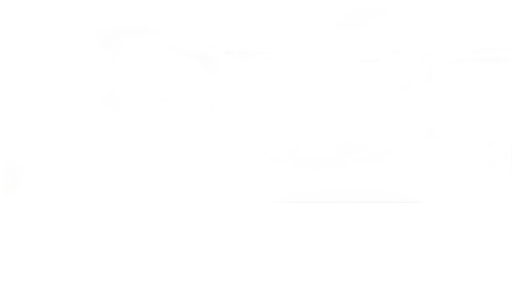
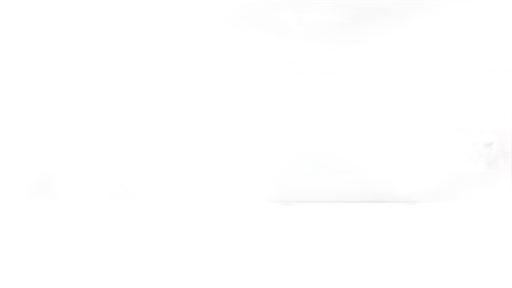

In [9]:
from IPython.display import display, HTML

display(HTML(html_viewer(layers, depths)))